In [5]:
# Load needed libraries

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import os, pathlib
import cv2

from tensorflow import keras  
from tensorflow.keras import models
from tensorflow.keras import Model 
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
import keras.backend as K

In [6]:
# Function to make graphs to compare valid and train metrics
def plot_train_instrumentation(epochs, data, train_param, val_param):
    
    plt.figure(figsize=(10,7))
    
    plt.plot(epochs, data[train_param], 'g', label=f'Training ({train_param})')
    plt.plot(epochs, data[val_param], 'red', label=f'Validation ({val_param})')
    
    plt.title("Training performance")
    plt.xlabel('Epochs')
    plt.ylabel(train_param)
    
    plt.legend()
    plt.show()

In [7]:
# Function to count number of file for each class in subfolder
def count_files_in_subfolder(subfolder):
    
    for path in pathlib.Path(subfolder).iterdir():
        if path.is_dir():
            print("Class " + str(path.name) + ": " + \
                  str(len([name for name in os.listdir(path) \
            if os.path.isfile(os.path.join(path, name))])) + " files")

## Loading data
### I have chosen Vegetable Image Dataset because it was the most interesting case for me.

In [8]:
# Load data from specified path
dataset='../input/vegetable-image-dataset/Vegetable Images'

train_folder = os.path.join(dataset,"train")
valid_folder = os.path.join(dataset,"validation")
test_folder = os.path.join(dataset,"test")

## Exploration of data

Image dimensions: (224, 224, 3)


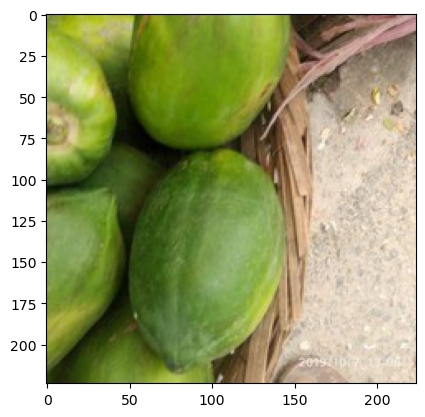

In [9]:
# See the example of image
image_example = mpimg.imread('/kaggle/input/vegetable-image-dataset/Vegetable Images/train/Papaya/0436.jpg')

# Print out the image dimensions
print('Image dimensions:', image_example.shape)
plt.imshow(image_example)

In [10]:
# Specify inage dimensions
IMAGE_SHAPE = (224, 224)

# Load data
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(
    train_folder,
    shuffle=True,
    target_size=IMAGE_SHAPE,
)
valid_generator = datagen.flow_from_directory(
    valid_folder,
    shuffle=False,
    target_size=IMAGE_SHAPE,
)
test_generator = datagen.flow_from_directory(
    test_folder,
    shuffle=True,
    target_size=IMAGE_SHAPE,
)

# Check names and number of classes
names_of_classes = sorted(os.listdir(train_folder))
print(f"\nNames of Classes : {names_of_classes}".format(names_of_classes))
number_of_classes = len(names_of_classes)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.

Names of Classes : ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']


### There are in total 21 000 images with 224x224 pixels (15 000 = train, 3 000 = test, 3 000 = validation) that belong to 15 classes of vegetables.


In [11]:
# Check number of images in each subfolder for each class

print("Train data:")
count_files_in_subfolder(os.path.join(train_folder))
print("\nTest data:")
count_files_in_subfolder(os.path.join(test_folder))
print("\nValidation data:")
count_files_in_subfolder(os.path.join(valid_folder))

Train data:
Class Broccoli: 1000 files
Class Capsicum: 1000 files
Class Bottle_Gourd: 1000 files
Class Radish: 1000 files
Class Tomato: 1000 files
Class Brinjal: 1000 files
Class Pumpkin: 1000 files
Class Carrot: 1000 files
Class Papaya: 1000 files
Class Cabbage: 1000 files
Class Bitter_Gourd: 1000 files
Class Cauliflower: 1000 files
Class Bean: 1000 files
Class Cucumber: 1000 files
Class Potato: 1000 files

Test data:
Class Broccoli: 200 files
Class Capsicum: 200 files
Class Bottle_Gourd: 200 files
Class Radish: 200 files
Class Tomato: 200 files
Class Brinjal: 200 files
Class Pumpkin: 200 files
Class Carrot: 200 files
Class Papaya: 200 files
Class Cabbage: 200 files
Class Bitter_Gourd: 200 files
Class Cauliflower: 200 files
Class Bean: 200 files
Class Cucumber: 200 files
Class Potato: 200 files

Validation data:
Class Broccoli: 200 files
Class Capsicum: 200 files
Class Bottle_Gourd: 200 files
Class Radish: 200 files
Class Tomato: 200 files
Class Brinjal: 200 files
Class Pumpkin: 200 f

### We can see that classes in all parts of dataset are equally distributed. This means that data is balanced. It is good because classification models will not be biased towards any of classes.

## Metric

#### For models AUC (Area Under the Curve) was chosen as a metric because it is good for classification tasks. 

####  For example, its advantage is that it is classification-threshold-invariant like log loss, therefore it measures the quality of the model’s predictions irrespective of what classification threshold is chosen. AUC ranges in value from 0 to 1. A model whose predictions are 100% correct has an AUC of 1. And 0,5 means that classifier is random.

#### Then, for loss function the categorical crossentropy was used because it is usually applied when there is the case when target is categorical.

## Models

## 1) Transfer Learning. InceptionV3 without data augmentation

In [12]:
# Set image dimensions
IMAGE_SIZE = [224, 224]

# Pretrained InceptionV3 model is applied
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Parameters in model are fixed
for layer in inception.layers:
    layer.trainable = False

# Final layers, pooling, dropout are added
x = inception.output

# Apply global average pooling
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)

# Add dropout to avoid overfitting
x = Dropout(0.2)(x)

# Specify that there are 15 classes
prediction = Dense(15, activation='softmax')(x)

model_inceptionv3 = Model(inputs=inception.input, outputs=prediction)

# Model is compiled
model_inceptionv3.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['AUC']
)

87910968/87910968 [==============================] - 1s 0us/step


In [13]:
# Set early stopping criterion, number of epochs, batch size
early_stop = EarlyStopping(monitor='loss', patience=5)
EPOCHS = 5
BATCH_SIZE = 64

# Fir the model
history_model_inceptionv3 = model_inceptionv3.fit(train_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE // 2,
                    epochs=EPOCHS,
                    validation_data=valid_generator,
                    validation_steps= valid_generator.samples // BATCH_SIZE // 2,
                    verbose=1,
                    callbacks=[early_stop]
                    )

Epoch 1/5
117/117 [==============================] - 230s 2s/step - loss: 0.5287 - auc: 0.9879 - val_loss: 0.1135 - val_auc: 0.9997
Epoch 2/5
117/117 [==============================] - 225s 2s/step - loss: 0.1543 - auc: 0.9977 - val_loss: 0.0483 - val_auc: 0.9999
Epoch 3/5
117/117 [==============================] - 226s 2s/step - loss: 0.0679 - auc: 0.9996 - val_loss: 0.0311 - val_auc: 1.0000
Epoch 4/5
117/117 [==============================] - 226s 2s/step - loss: 0.0694 - auc: 0.9997 - val_loss: 0.0692 - val_auc: 0.9991
Epoch 5/5
117/117 [==============================] - 226s 2s/step - loss: 0.0636 - auc: 0.9997 - val_loss: 0.0791 - val_auc: 0.9991


In [14]:
history_dict_model_inceptionv3 = history_model_inceptionv3.history

print(history_dict_model_inceptionv3.keys())

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


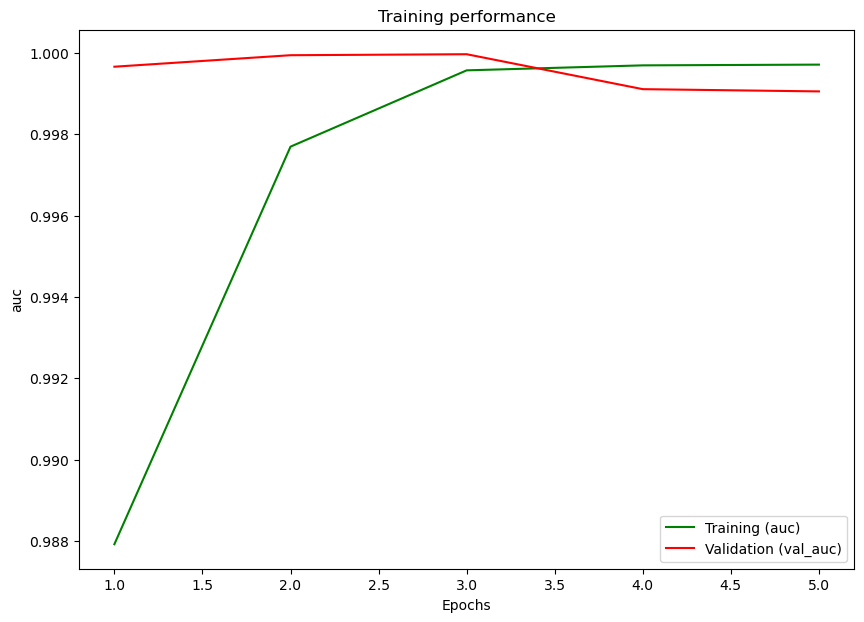

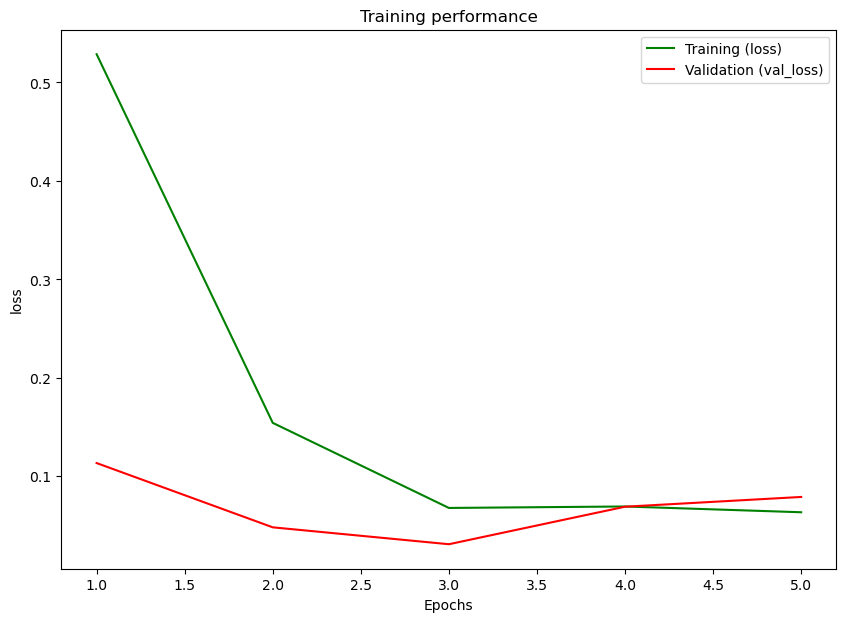

In [15]:
# Plot results of AUC and loss on train and validation sets
epochs = range(1, len(history_dict_model_inceptionv3['auc'])+1)

plot_train_instrumentation(epochs, history_dict_model_inceptionv3, 'auc', 'val_auc')
plot_train_instrumentation(epochs, history_dict_model_inceptionv3, 'loss', 'val_loss')

In [16]:
# Evaluation on test Set
model_inceptionv3.evaluate(test_generator)

94/94 [==============================] - 147s 2s/step - loss: 0.0493 - auc: 0.9996


[0.049349039793014526, 0.9995710253715515]

## 2) Transfer Learning. InceptionV3 with data augmentation

In [17]:
# Add augmentation to train data
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.,
                                  rotation_range=40,
                                  shear_range=.2,
                                  zoom_range=.2,
                                  width_shift_range=.2,
                                  height_shift_range=.2,
                                  horizontal_flip=True
    
)

train_generator_augmented = train_datagen.flow_from_directory(
    train_folder,
    shuffle=True,
    target_size=IMAGE_SHAPE,
 )

Found 15000 images belonging to 15 classes.


In [18]:
# Set image dimensions
IMAGE_SIZE = [224, 224]

# Pretrained InceptionV3 model (ready architecture) is applied
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Parameters in model are fixed
for layer in inception.layers:
    layer.trainable = False

# Final layers, pooling, dropout are added
x = inception.output

# Apply global average pooling
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)

# Add dropout to avoid overfitting
x = Dropout(0.2)(x)

# Specify that there are 15 classes
prediction = Dense(15, activation='softmax')(x)

model_inceptionv3_aug = Model(inputs=inception.input, outputs=prediction)

# Model is compiled
model_inceptionv3_aug.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), 
                               loss='categorical_crossentropy',
                               metrics=['AUC'])

# Summary of model is not printed here because it is huge
#print(model_inceptionv3_aug.summary())

In [19]:
# Set early stopping criterion, number of epochs, batch size
early_stop = EarlyStopping(monitor='loss', patience=5)
EPOCHS = 5
BATCH_SIZE = 64

# Fit the model
history_model_inceptionv3_aug = model_inceptionv3_aug.fit(
        train_generator_augmented,
        steps_per_epoch=train_generator_augmented.samples // BATCH_SIZE // 2,
        epochs=EPOCHS,
        validation_data=valid_generator, 
        validation_steps= valid_generator.samples // BATCH_SIZE // 2,
        verbose=1,
        callbacks=[early_stop])


Epoch 1/5
117/117 [==============================] - 249s 2s/step - loss: 1.2682 - auc: 0.9465 - val_loss: 0.1534 - val_auc: 0.9986
Epoch 2/5
117/117 [==============================] - 241s 2s/step - loss: 0.5516 - auc: 0.9848 - val_loss: 0.2924 - val_auc: 0.9958
Epoch 3/5
117/117 [==============================] - 239s 2s/step - loss: 0.4751 - auc: 0.9874 - val_loss: 0.1567 - val_auc: 0.9979
Epoch 4/5
117/117 [==============================] - 243s 2s/step - loss: 0.4150 - auc: 0.9895 - val_loss: 0.2607 - val_auc: 0.9910
Epoch 5/5
117/117 [==============================] - 243s 2s/step - loss: 0.4458 - auc: 0.9885 - val_loss: 0.1446 - val_auc: 0.9979


In [20]:
history_model_inceptionv3_aug_dict = history_model_inceptionv3_aug.history

print(history_model_inceptionv3_aug_dict.keys())

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


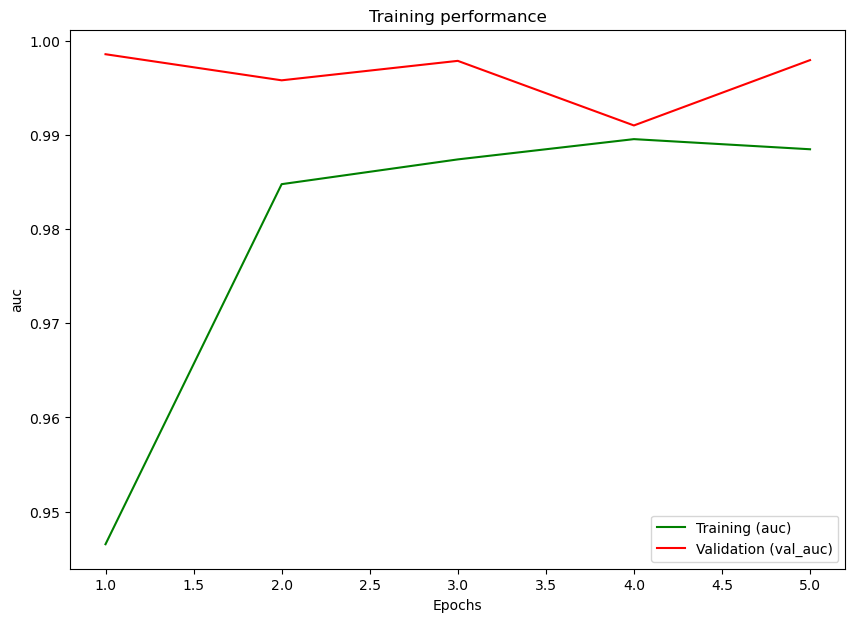

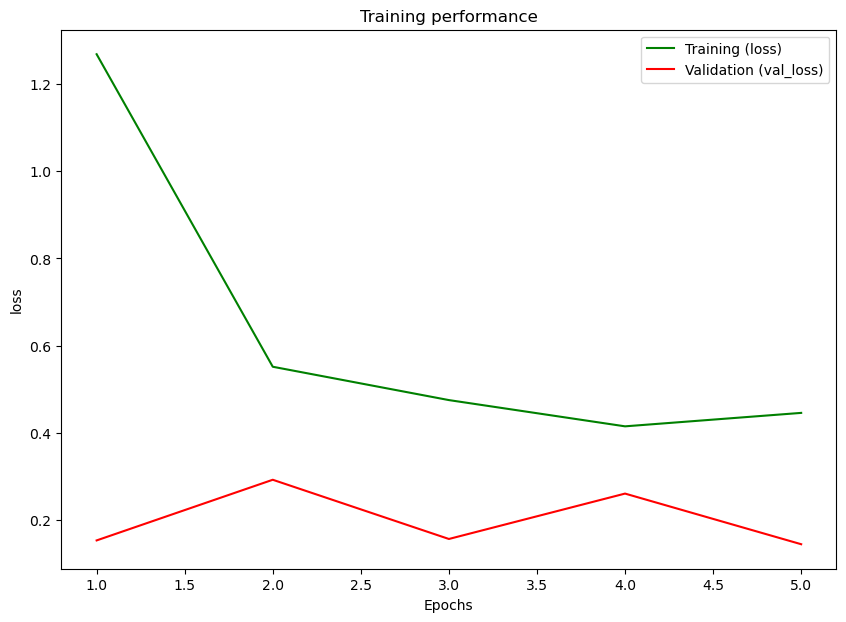

In [21]:
# Plot results of AUC and loss on train and validation sets
epochs = range(1, len(history_model_inceptionv3_aug_dict['auc'])+1)

plot_train_instrumentation(epochs, history_model_inceptionv3_aug_dict, 'auc', 'val_auc')
plot_train_instrumentation(epochs, history_model_inceptionv3_aug_dict, 'loss', 'val_loss')

In [22]:
# Evaluation on test Set
test_loss_inceptionv3_aug, test_AUC_inceptionv3_aug = model_inceptionv3_aug.evaluate(test_generator)
test_loss_inceptionv3_aug, test_AUC_inceptionv3_aug

94/94 [==============================] - 150s 2s/step - loss: 0.1622 - auc: 0.9981


(0.16217494010925293, 0.9980811476707458)

## 3) ResNet152V2 model without data augmentation

In [23]:
# Set image dimensions
IMAGE_SIZE = [224, 224]

# Pretrained ResNet152V2 model is applied
resnet152v2 = keras.applications.ResNet152V2(input_shape=IMAGE_SIZE + [3], weights='imagenet', 
                                                       include_top=False)

# Parameters in model are fixed
for layer in resnet152v2.layers:
    layer.trainable = False

# Final layers, pooling, dropout are added
x = resnet152v2.output

# Apply global average pooling
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)

# Add dropout to avoid overfitting
x = Dropout(0.5)(x)

# Specify that there are 15 classes
prediction = Dense(15, activation='softmax')(x)


model_resnet152v2 = Model(inputs=resnet152v2.input, outputs=prediction)

# Model is compiled
model_resnet152v2 .compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['AUC']
)

234545216/234545216 [==============================] - 2s 0us/step


In [24]:
# Set early stopping criterion, number of epochs, batch size
early_stop = EarlyStopping(monitor='loss', patience=5)
EPOCHS = 5
BATCH_SIZE = 64

# Fit the model
history_model_resnet152v2 = model_resnet152v2.fit(train_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE // 2,
                    epochs=EPOCHS,
                    validation_data=valid_generator,
                    validation_steps= valid_generator.samples // BATCH_SIZE // 2,
                    verbose=1,
                    callbacks=[early_stop]
                    )

Epoch 1/5
117/117 [==============================] - 889s 8s/step - loss: 0.5430 - auc: 0.9856 - val_loss: 0.0827 - val_auc: 0.9977
Epoch 2/5
117/117 [==============================] - 865s 7s/step - loss: 0.1266 - auc: 0.9985 - val_loss: 0.0494 - val_auc: 0.9992
Epoch 3/5
117/117 [==============================] - 873s 7s/step - loss: 0.0992 - auc: 0.9984 - val_loss: 0.0385 - val_auc: 0.9993
Epoch 4/5
117/117 [==============================] - 924s 8s/step - loss: 0.0542 - auc: 0.9996 - val_loss: 0.0291 - val_auc: 0.9992
Epoch 5/5
117/117 [==============================] - 935s 8s/step - loss: 0.0598 - auc: 0.9991 - val_loss: 0.0256 - val_auc: 0.9993


In [25]:
history_dict_model_resnet152v2 =history_model_resnet152v2.history

print(history_dict_model_resnet152v2.keys())

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


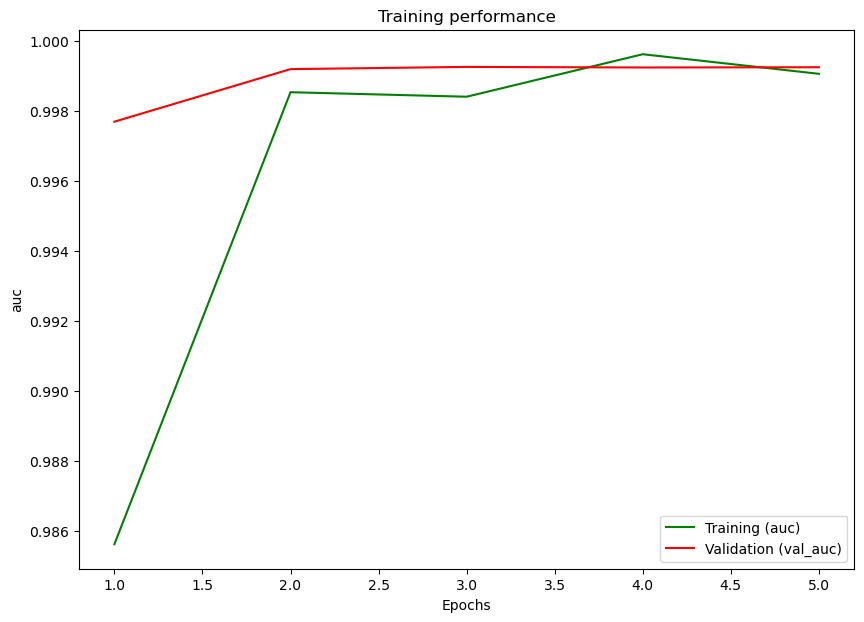

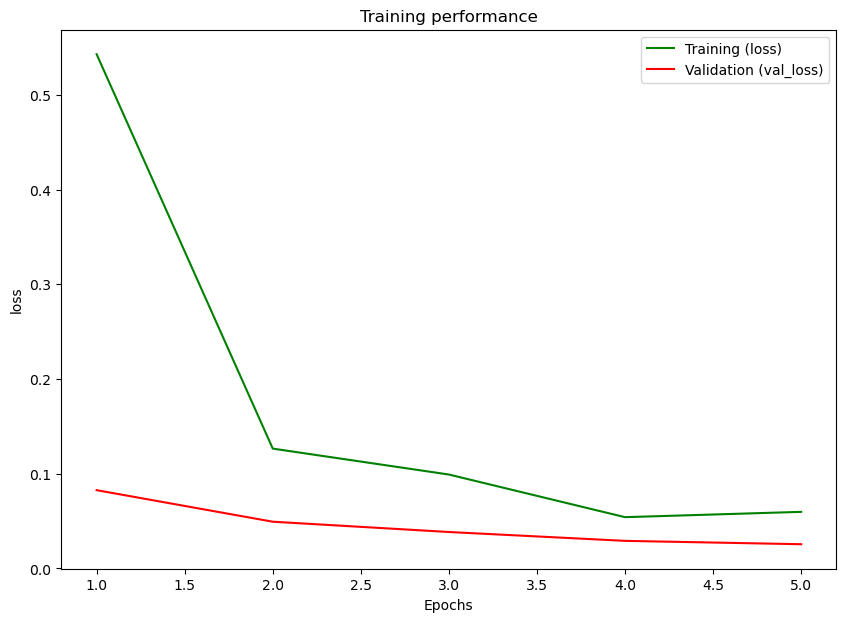

In [26]:
# Plot results of AUC and loss on train and validation sets
epochs = range(1, len(history_dict_model_resnet152v2['auc'])+1)

plot_train_instrumentation(epochs, history_dict_model_resnet152v2, 'auc', 'val_auc')
plot_train_instrumentation(epochs, history_dict_model_resnet152v2, 'loss', 'val_loss')

In [27]:
# Evaluation on test Set
model_resnet152v2.evaluate(test_generator)

94/94 [==============================] - 585s 6s/step - loss: 0.0203 - auc: 0.9996


[0.020301643759012222, 0.9996256828308105]

## 4) ResNet152V2 model with data augmentation

In [29]:
# Add augmentation to train data
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.,
                                  rotation_range=40,
                                  shear_range=.2,
                                  zoom_range=.2,
                                  width_shift_range=.2,
                                  height_shift_range=.2,
                                  horizontal_flip=True
    
)

train_generator_augmented = train_datagen.flow_from_directory(
    train_folder,
    shuffle=True,
    target_size=IMAGE_SHAPE,
 )

Found 15000 images belonging to 15 classes.


In [28]:
# Set image dimensions
IMAGE_SIZE = [224, 224]

# Pretrained ResNet152V2 model (ready architecture) is applied
resnet152v2 = keras.applications.ResNet152V2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Parameters in model are fixed
for layer in resnet152v2.layers:
    layer.trainable = False

# Final layers, pooling, dropout are added
x = resnet152v2.output

# Apply global average pooling
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)

# Add dropout to avoid overfitting
x = Dropout(0.5)(x)

# Specify that there are 15 classes
prediction = Dense(15, activation='softmax')(x)

model_resnet152v2_aug = Model(inputs=resnet152v2.input, outputs=prediction)

# Model is compiled
model_resnet152v2_aug.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), 
                               loss='categorical_crossentropy',
                               metrics=['AUC'])

# Summary of model is not printed here because it is huge
#print(model_inceptionv3_aug.summary())

In [30]:
# Set early stopping criterion, number of epochs, batch size
early_stop = EarlyStopping(monitor='loss', patience=5)
EPOCHS = 5
BATCH_SIZE = 64

# Fit the model
history_model_resnet152v2_aug = model_resnet152v2_aug.fit(
        train_generator_augmented,
        steps_per_epoch=train_generator_augmented.samples // BATCH_SIZE // 2,
        epochs=EPOCHS,
        validation_data=valid_generator, 
        validation_steps= valid_generator.samples // BATCH_SIZE // 2,
        verbose=1,
        callbacks=[early_stop])

Epoch 1/5
117/117 [==============================] - 899s 8s/step - loss: 1.0356 - auc: 0.9573 - val_loss: 0.1856 - val_auc: 0.9975
Epoch 2/5
117/117 [==============================] - 941s 8s/step - loss: 0.6231 - auc: 0.9818 - val_loss: 0.1720 - val_auc: 0.9945
Epoch 3/5
117/117 [==============================] - 936s 8s/step - loss: 0.6275 - auc: 0.9820 - val_loss: 0.1072 - val_auc: 0.9983
Epoch 4/5
117/117 [==============================] - 882s 8s/step - loss: 0.5685 - auc: 0.9833 - val_loss: 0.0905 - val_auc: 0.9984
Epoch 5/5
117/117 [==============================] - 882s 8s/step - loss: 0.5493 - auc: 0.9835 - val_loss: 0.0934 - val_auc: 0.9977


In [31]:
history_model_resnet152v2_aug_dict = history_model_resnet152v2_aug.history

print(history_model_resnet152v2_aug_dict.keys())

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


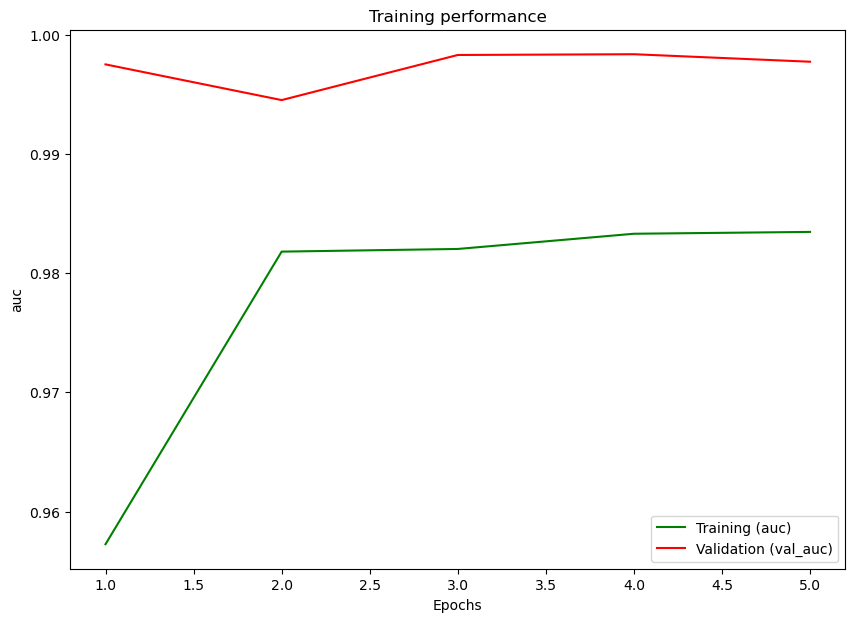

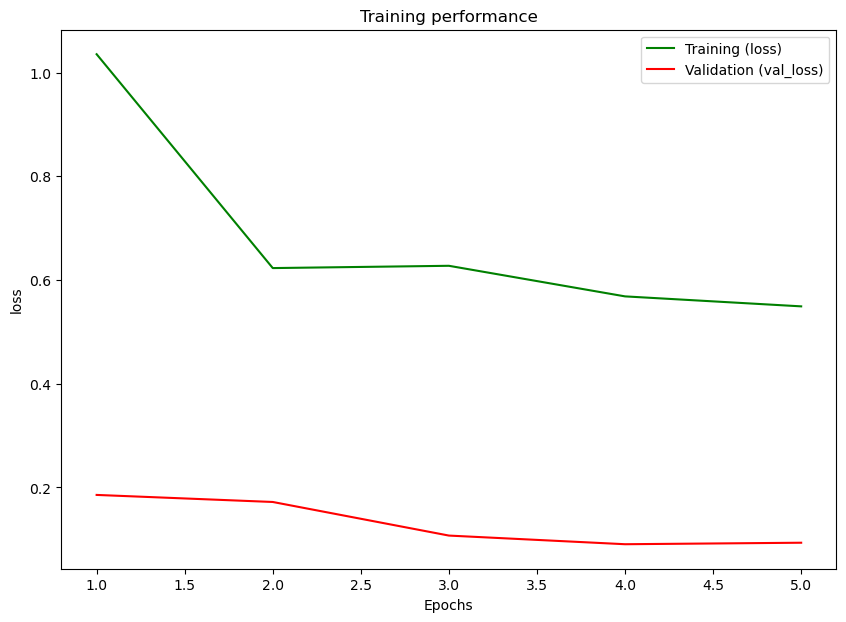

In [32]:
# Plot results of AUC and loss on train and validation sets
epochs = range(1, len(history_model_resnet152v2_aug_dict['auc'])+1)

plot_train_instrumentation(epochs, history_model_resnet152v2_aug_dict, 'auc', 'val_auc')
plot_train_instrumentation(epochs, history_model_resnet152v2_aug_dict, 'loss', 'val_loss')

In [33]:
# Evaluation on test Set
test_loss_inceptionv3_aug, test_AUC_resnet152v2_aug = model_resnet152v2_aug.evaluate(test_generator)
test_loss_inceptionv3_aug, test_AUC_resnet152v2_aug

94/94 [==============================] - 578s 6s/step - loss: 0.0878 - auc: 0.9978


(0.08783045411109924, 0.9977934956550598)

In [34]:
# Save models
model_inceptionv3.save('model_inceptionv3')
model_inceptionv3_aug.save('model_inceptionv3_aug')
model_resnet152v2.save('model_resnet152v2')
model_resnet152v2_aug.save('model_resnet152v2_aug')

## Conclusions:

### I have used two well-known architectures: InceptionV3 and ResNet152V2 (with and without data augmentation). All models show extremely good results on test data (as well as on validation and train) in terms of AUC score (close to 1) and loss (close to 0). But the best result showed ResNet152V2 model without data augmentation (3rd model).

### Interestingly, models with data augmentation show slightly worse results (but still very good) than models without it. There may be many reasons why this is the case. In order to improve the results, it would be possible to take a larger dataset, if there was such an opportunity, so that the model had more examples. Or the model was trained for a too small amount of time and setting the number of iterations to a bigger value might be a good idea for the improvement. It can also help to vary data augmentation techniques: rotate the image, change the angle, and so on.

### The Results of models are summarized in the table below.

|**Model number**| **Model**                                |**Loss (test)**|**AUC (test)**|
|:--------------:|------------------------------------------|:-------------:|:------------:|
|1               | InceptionV3 without data augmentation    | 0.0493        | 0.9996       |
|2               | InceptionV3 with data augmentation       | 0.1622        | 0.9981       |
|**3**          | **ResNet152V2 without data augmentation**| **0.0203**    | **0.9996**   |
|4               | ResNet152V2 with data augmentation       | 0.0878        | 0.9978       |